In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as graph
import seaborn as sns

# HOG Features <br>

The Histogram of Gradients is a straightforward feature extraction procedure that was developed in the context of identifying pedestrians within images. HOG involves the following steps:

1. Optionally pre-normalize images. This leads to features that resist dependence on variations in illumination.
2. Convolve the image with two filters that are sensitive to horizontal and vertical brightness gradients. These capture edge, contour, and texture information.
3. Subdivide the image into cells of a predetermined size, and compute a histogram of the gradient orientations within each cell.
4. Normalize the histograms in each cell by comparing to the block of neighboring cells. This further suppresses the effect of illumination across the image.
5. Construct a one-dimensional feature vector from the information in each cell.

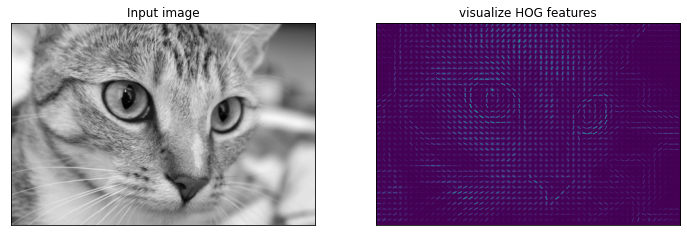

In [5]:
from skimage import data, color, feature
import skimage.data

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)

fig, ax = graph.subplots(1, 2, figsize=(12, 6), subplot_kw = dict(xticks=[], yticks=[]))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualize HOG features')

graph.show()

# HOG in action: A simple face detector

Steps: 

1. Obtain a set of image thumbnails of faces to constitute "positive" training samples.
2. Obtain a set of image thumbnails of non-faces to constitute "negative" training samples.
3. Extract HOG features from these training samples.
4. Train a linear SVM classifier on these samples.
5. For an "unknown" image, pass a sliding window across the image, using the model to evaluate whether that window contains a face or not.
6. If detections overlap, combine them into a single window.

In [6]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [7]:
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

In [8]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

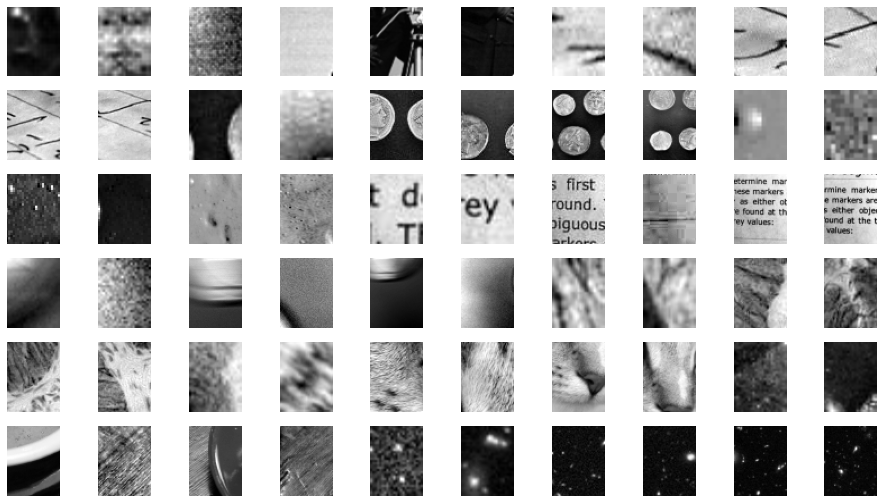

In [10]:
fig, ax = graph.subplots(6, 10, figsize=(16, 9))

for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

In [11]:
from itertools import chain

x_train = np.array([feature.hog(im) for im in chain(positive_patches, negative_patches)])
y_train = np.zeros(x_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [12]:
x_train.shape, y_train.shape

((43233, 1215), (43233,))

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), x_train, y_train)

array([0.94784318, 0.97189777, 0.97236036, 0.97490169, 0.97374508])

In [14]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(x_train, y_train)
grid.best_score_

/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the num

0.9884578497284486

In [16]:
from sklearn.linear_model import LogisticRegression

grid = GridSearchCV(LogisticRegression(solver='saga'), {'penalty': ['l1', 'l2', 'elasticnet'], 
                                           'C': [1.0, 2.0, 4.0, 8.0]}, n_jobs=-1)
grid.fit(x_train, y_train)
grid.best_score_

0.9891980871235028

In [20]:
grid.best_params_

{'C': 1.0, 'penalty': 'l2'}

In [21]:
model = grid.best_estimator_
model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

# Find new image

(-0.5, 255.5, 255.5, -0.5)

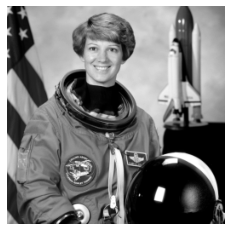

In [29]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
# test_image = test_image[:160, 40:180]

graph.imshow(test_image, cmap='gray')
graph.axis('off')

In [30]:
def sliding_window(img, patch_size=positive_patches[0].shape, istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(9409, 1215)

In [31]:
labels = model.predict(patches_hog)
labels.sum()

184.0

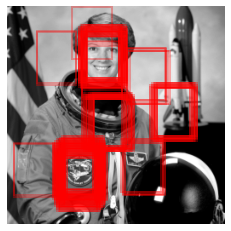

In [32]:
fig, ax = graph.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(graph.Rectangle((j, i), Nj, Ni, edgecolor='red', alpha=0.3, lw=2, facecolor='none'))